Cross-validated Mean Absolute Error: 0.0348

--- Model Evaluation Metrics ---
R-squared: 0.9990
Mean Absolute Error (MAE): 0.0229
Cross-validated MAE: 0.0348


Dropdown(description='Select Genre:', options=('Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle'…

Output()

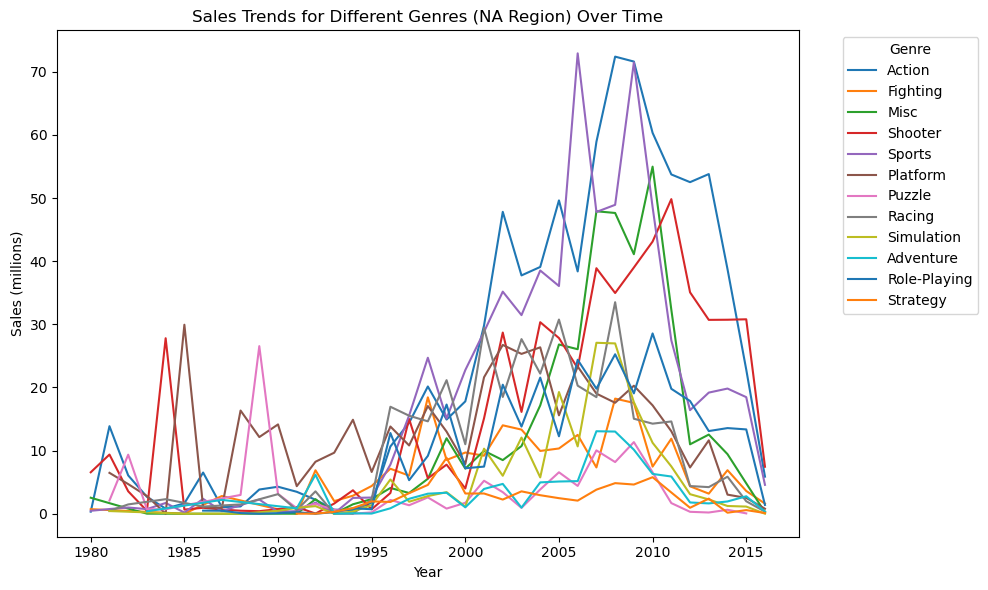

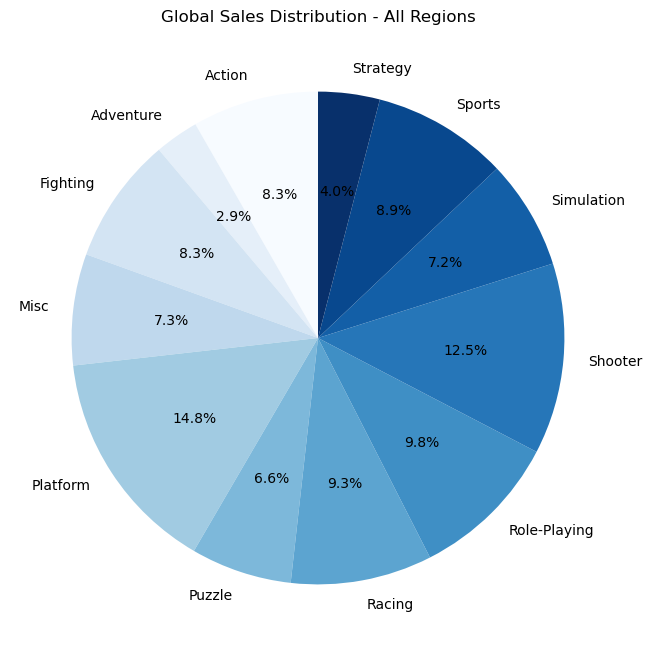

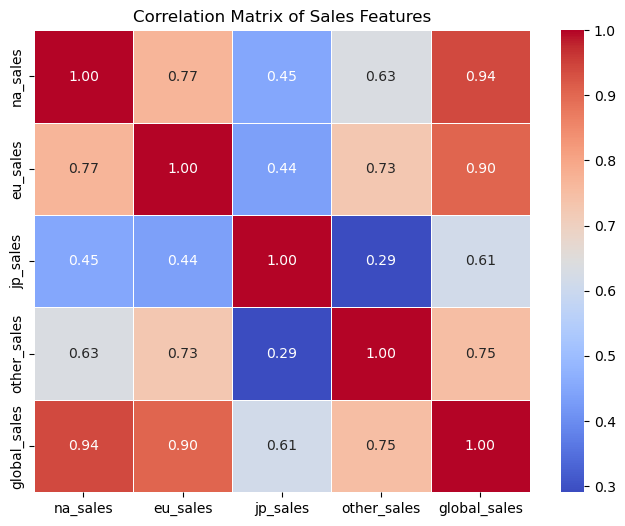

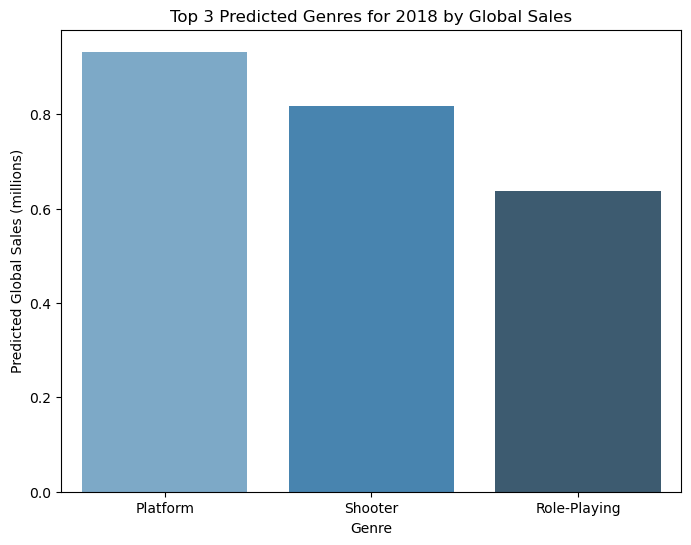

In [ ]:

##############################################
#                                           
#        Video Game Genre Prediction Model
#           Created By: John McGinnes
#                   03/21/2025
#
##############################################

##############################################
#                                           
#           Libraries Imported
#
##############################################

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os

##############################################
#                                           
#                Read Data
#
##############################################

# Get the directory of the current Jupyter Notebook
notebook_dir = os.path.dirname(os.path.realpath("__file__"))

# Define the path to the CSV file in the same directory
csv_file_path = os.path.join(notebook_dir, 'Video_Games_Sales_as_of_2016.csv')

# Load the dataset
df = pd.read_csv(csv_file_path)

##############################################
#                                           
#            Data Processing
#
##############################################

# Preprocessing and handling missing sales data
df['na_sales'] = df['na_sales'].fillna(df['na_sales'].mean())
df['eu_sales'] = df['eu_sales'].fillna(df['eu_sales'].mean())
df['jp_sales'] = df['jp_sales'].fillna(df['jp_sales'].mean())
df['other_sales'] = df['other_sales'].fillna(df['other_sales'].mean())

 # Ensure 'year' is an integer
df['year'] = df['year'].astype(int) 

# Apply Label Encoding to categorical columns ('genre' and 'publisher')
label_encoder_genre = LabelEncoder()
df['genre_encoded'] = label_encoder_genre.fit_transform(df['genre'])

label_encoder_publisher = LabelEncoder()
df['publisher_encoded'] = label_encoder_publisher.fit_transform(df['publisher'].astype(str))

# Filter data for years <= 2016 for training
train_df = df[df['year'] <= 2016]

# Prepare the features and target variable for model training
X_train = train_df[['genre_encoded', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
y_train = train_df['global_sales']

##############################################
#                                           
#     Machine Learning Model Training
#
##############################################

# Initialize the GradientBoostingRegressor model
model = GradientBoostingRegressor()

# Perform Cross-Validation (5-fold) and evaluate the MAE
cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cross_val_mae = -cross_val_scores.mean()
print(f'Cross-validated Mean Absolute Error: {cross_val_mae:.4f}')

# Fit the model on the full training data
model.fit(X_train, y_train)

# Calculate the average sales per genre across all years
genre_sales_avg = df.groupby('genre').agg({
    'na_sales': 'mean',
    'eu_sales': 'mean',
    'jp_sales': 'mean',
    'other_sales': 'mean'
}).reset_index()

#Calculate global sales by summing sales across all regions for each genre
genre_sales_avg['global_sales_avg'] = genre_sales_avg[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

##############################################
#                                           
#      Machine Learning Model Predictions
#
##############################################

# Create a prediction dataset for all genres in 2018
predict_2018_data = {
    'genre_encoded': label_encoder_genre.transform(genre_sales_avg['genre']),
    'na_sales': genre_sales_avg['na_sales'],
    'eu_sales': genre_sales_avg['eu_sales'],
    'jp_sales': genre_sales_avg['jp_sales'],
    'other_sales': genre_sales_avg['other_sales']
}

predict_df = pd.DataFrame(predict_2018_data)

# Make predictions for global sales in 2018
X_predict = predict_df[['genre_encoded', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']]
y_pred_2018 = model.predict(X_predict)

# Store predicted sales for all genres for 2018
predict_df['predicted_sales_2018'] = y_pred_2018

#Convert encoded genre labels back to the original strings
predict_df['genre'] = label_encoder_genre.inverse_transform(predict_df['genre_encoded'])

# Sort the genres by the predicted sales in 2018 and assign a rank to each genre
top_genres_2018 = predict_df[['genre', 'predicted_sales_2018']].sort_values(by='predicted_sales_2018', ascending=False).reset_index(drop=True)
top_genres_2018['Rank'] = top_genres_2018.index + 1

##############################################
#                                           
#           Accuracy Metrics
#
##############################################

# Model evaluation metrics (R-squared, MAE, and Cross-Validation Score)
y_train_pred = model.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)
print("\n--- Model Evaluation Metrics ---")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Cross-validated MAE: {cross_val_mae:.4f}")

##############################################
#                                           
#          User Interaction Widget
#
##############################################

# Widget for genre selection to show any genre's predicted sales
genre_dropdown = widgets.Dropdown(
    options=predict_df['genre'].tolist(),
    description='Select Genre:',
    disabled=False,
)
# Display predicted sales when a genre is selected
output = widgets.Output()

# Function definition that updates the output when a genre is selected
def on_genre_selected(change):
    selected_genre = change['new']
    genre_sales = predict_df[predict_df['genre'] == selected_genre]['predicted_sales_2018'].values[0]
    with output:
        output.clear_output()  # Clear previous output
        print(f"Predicted sales for {selected_genre} in 2018: {genre_sales:.4f} million units")

# Link the dropdown to the function
genre_dropdown.observe(on_genre_selected, names='value')

# Display the dropdown and output area
display(genre_dropdown, output)

##############################################
#                                           
#              Visualizations
#
##############################################

# Visualization 1: Line Plot Showing Sales Trends Over Time for Different Genres
plt.figure(figsize=(10, 6))
genre_sales_trends = df.groupby(['year', 'genre'])[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum().reset_index()
sns.lineplot(data=genre_sales_trends, x='year', y='na_sales', hue='genre', palette="tab10")
plt.title('Sales Trends for Different Genres (NA Region) Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (millions)')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualization 2: Pie Chart for Distribution of Sales by Region 
sales_by_region = genre_sales_avg[['genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']].set_index('genre').sum(axis=1)
plt.figure(figsize=(8, 8))
sales_by_region.plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='Blues')
plt.title('Global Sales Distribution - All Regions')
plt.ylabel('')
plt.show()

# Visualization 3: Heatmap of Feature Correlations
corr_matrix = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'global_sales']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Sales Features')
plt.show()

# Visualization 4: Plot the top 3 genres' predicted sales for 2018
plt.figure(figsize=(8, 6))
sns.barplot(x='genre', y='predicted_sales_2018', data=top_genres_2018.head(3), palette="Blues_d", hue='genre', legend=False)
plt.title('Top 3 Predicted Genres for 2018 by Global Sales')
plt.xlabel('Genre')
plt.ylabel('Predicted Global Sales (millions)')
plt.show()
